In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import matplotlib.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as st
from collections import OrderedDict, defaultdict
from scipy.stats import ks_2samp, kstest, chisquare
import re
import matplotlib.patches as mpatches


import warnings
warnings.filterwarnings("ignore")

In [2]:
#plt.style.use('default')
sns.set()

In [3]:
def PrepareDataFrame(df_raw):
    df_raw.fillna(value=np.nan, inplace=True)
    df_raw.drop(df_raw.loc[:,'NO':].columns, axis=1, inplace=True)
    df_raw.drop(df_raw.loc[:,'ST':'DU'].columns, axis=1, inplace=True)
    df_raw.dropna(subset=['YY','MM', 'DD'], inplace=True)
    #приведем столбцы с датой к int, сбросим индексы ввиду манипуляций с удалениями, чтобы навести порядок
    df_raw.loc[:, 'YY':'DD'] = df_raw.loc[:, 'YY':'DD'].astype(int)
    df_raw.reset_index(drop=True, inplace=True)
    for i, x in enumerate(df_raw['YY']):
        df_raw.loc[i, 'YY'] = 1900 + x if x >= 83 else 2000 + x
    date_column, index_error = [], []
    for i in range(df_raw.shape[0]):
        try:
            date_column.append(datetime.date(df_raw.iloc[i,0],df_raw.iloc[i,1],df_raw.iloc[i,2]))
        except ValueError:
            index_error.append(i)
    print('Некорректные строки удалены:\n')
    print(df_raw.iloc[index_error,:])
    df_raw.drop(index_error, axis = 0, inplace=True)
    df_raw.reset_index(drop=True, inplace=True)
    #приведение необходимых параметров к типу числовым типам(избавление от типа object)
    df_raw = df_raw.apply(pd.to_numeric, errors='coerce')
    df_raw.insert(0, 'Time', date_column)
    ##############################################################################################################
    #в дальнейшем не понадобится, но удобно смотреть на то, какой по счету нужный месяц
    #months = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,
    #      'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
    ##############################################################################################################
    return df_raw

In [4]:
#подготовим данные по временам года
def PrepareSeasonalDataFrame(df):
    wind = df[df['MM'].isin([12, 1, 2])].reset_index(drop=True)
    sprd = df[df['MM'].isin([3, 4, 5])].reset_index(drop=True)
    sumd = df[df['MM'].isin([6, 7, 8])].reset_index(drop=True)
    autd = df[df['MM'].isin([9, 10, 11])].reset_index(drop=True)
    return wind,sprd,sumd,autd

In [5]:
#загрузили исходные данные
df_raw = pd.read_excel(r'Prioksk_Air_in.xlsx')
#очистили их от того, что не потребуется и что может привести к ошибкам
df = PrepareDataFrame(df_raw.copy())
#создадим копию для удобства
data_total = df.copy()
winter_data, spring_data, summer_data, autumn_data = PrepareSeasonalDataFrame(df.copy())

Некорректные строки удалены:

        YY  MM  DD  TSP  SO2  SO4   HG   PB   CD  NO2
5187  1998   9  31  NaN  0.0  NaN  NaN  NaN  NaN  NaN


In [6]:
def ExtractNotNullData(dataframe, element, with_zero=True):
    notnulldata = OrderedDict()
    if with_zero == True:
        for i in range(dataframe.shape[0]):
            if np.isnan(dataframe.loc[i, element]) == False:
                notnulldata[dataframe.loc[i,'Time']] = dataframe.loc[i, element]
    else:
        for i in range(dataframe.shape[0]):
            if np.isnan(dataframe.loc[i, element]) == False and dataframe.loc[i, element] != 0:
                notnulldata[dataframe.loc[i,'Time']] = dataframe.loc[i, element]
    return notnulldata

def CreateDataBySeasons(element, with_zero=True):
    return {'all':ExtractNotNullData(data_total, element, with_zero), 'winter':ExtractNotNullData(winter_data, element,with_zero),
           'spring':ExtractNotNullData(spring_data,element,with_zero), 'summer':ExtractNotNullData(summer_data, element,with_zero),
           'autumn':ExtractNotNullData(autumn_data, element,with_zero)}


def ExtractValues(data):
    return {'all':np.array(list(data['all'].values())),'winter':np.array(list(data['winter'].values())),
           'spring':np.array(list(data['spring'].values())), 'summer':np.array(list(data['summer'].values())),
           'autumn':np.array(list(data['autumn'].values()))}    

In [85]:
def GetBestDistribution(data):
    train, test = train_test_split(data, test_size=0.1)
    dist_names = ['expon', 'genexpon', 'gamma','gengamma','invgamma','loggamma','lognorm']
    
    #['alpha', 'beta', 'expon', 'genexpon', 'gamma','gengamma','invgamma','loggamma',
     #             'lognorm','mielke','ncf','powerlognorm','recipinvgauss', 'johnsonsu']
        
    dist_results_KS = []
    dist_results_Chi2 = []
    params_chi2 = {}
    params_ks = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        params1 = dist.fit(train, floc=0)
        params2 = dist.fit(train, loc=0)
        
        S1, p_chi2_1 = ChiSquareOnTest(test, dist_name, params1)
        S2, p_chi2_2 = ChiSquareOnTest(test, dist_name, params2)
        S, p_chi2, param_chi2 = (S1, p_chi2_1, params1) if p_chi2_1 > p_chi2_2 else (S2, p_chi2_2, params2)
        
        params_chi2[dist_name] = param_chi2
        
        D1, p_ks_1 = st.kstest(test, dist_name, args=params1)
        D2, p_ks_2 = st.kstest(test, dist_name, args=params2)
        D, p_ks, param_ks = (D1, p_ks_1, params1) if p_ks_1 > p_ks_2 else (D2, p_ks_2, params2)
        
        params_ks[dist_name] = param_ks
        
        #print("p value on K-S for "+dist_name+" = "+str(p_ks))
        #print("p value on Chi2 for "+dist_name+" = "+str(p_chi2))
        dist_results_KS.append((dist_name, p_ks))
        dist_results_Chi2.append((dist_name,p_chi2))
    
    #select the best fitted distribution on Chi2
    best_dist_chi2, best_p_chi2 = (max(dist_results_Chi2, key=lambda item: item[1]))
    #select the best fitted distribution on KS
    best_dist_ks, best_p_ks = (max(dist_results_KS, key=lambda item: item[1]))
    
    f1, f2 = False, False
    it_ks, it_chi2 = 0,0
    if best_p_ks < 0.05:
        f1 = True
        l1_dist_param = {}
        l1_dist_pv = []
        while p_ks < 0.05 and it_ks < 2:
            train, test = train_test_split(data, test_size=0.1)
            for dist_name in dist_names:
                name = dist_name + '_' + str(it_ks)
                dist = getattr(st, dist_name)
                params1 = dist.fit(train, floc=0)
                params2 = dist.fit(train, loc=0)
                D1, p_ks_1 = st.kstest(test, dist_name, args=params1)
                D2, p_ks_2 = st.kstest(test, dist_name, args=params2)
                D, p_ks, param_ks = (D1, p_ks_1, params1) if p_ks_1 > p_ks_2 else (D2, p_ks_2, params2)
                l1_dist_param[name] = param_ks
                l1_dist_pv.append((name, p_ks))
            it_ks += 1
            l1_best_dist, l1_best_pv = (max(l1_dist_pv, key=lambda item: item[1]))
        if l1_best_pv > best_p_ks:
            best_p_ks = l1_best_pv
            best_dist_ks = re.split('[_]', l1_best_dist)[0]
            new_params_ks = l1_dist_param[l1_best_dist]
        else:
            f1 = False

    if best_p_chi2 < 0.05:
        f2 = True
        l2_dist_param = {}
        l2_dist_pv = []
        while p_chi2 < 0.05 and it_chi2 < 2:
            train, test = train_test_split(data, test_size=0.1)
            for dist_name in dist_names:
                name = dist_name + '_' + str(it_chi2)
                dist = getattr(st, dist_name)
                params1 = dist.fit(train, floc=0)
                params2 = dist.fit(train, loc=0)
                S1, p_chi2_1 = ChiSquareOnTest(test, dist_name, params1)
                S2, p_chi2_2 = ChiSquareOnTest(test, dist_name, params2)
                S, p_chi2, param_chi2 = (S1, p_chi2_1, params1) if p_chi2_1 > p_chi2_2 else (S2, p_chi2_2, params2)
                l2_dist_param[name] = param_chi2
                l2_dist_pv.append((name, p_chi2))
            it_chi2 += 1
            l2_best_dist, l2_best_pv = (max(l2_dist_pv, key=lambda item: item[1]))
        if l2_best_pv > best_p_chi2:
            best_p_chi2 = l2_best_pv
            best_dist_chi2 = re.split('[_]', l2_best_dist)[0]
            new_params_chi2 = l2_dist_param[l2_best_dist]
        else:
            f2 = False
            
    print('\nChi2')
    print("Best fitting distribution: "+str(best_dist_chi2))
    print("Best p value: "+ str(best_p_chi2))
    if f2 == False:
        print("Parameters for the best fit: "+ str(params_chi2[best_dist_chi2]))
    elif best_p_chi2 >= 0.05:
        print("Parameters for the best fit: "+ str(new_params_chi2))
    elif best_p_chi2 <= 0.05:
        print('!!!Optimal Distribution on Chi Square was not found!!!')
        
    print('\nK-S')
    print("Best fitting distribution: "+str(best_dist_ks))
    print("Best p value: "+ str(best_p_ks))
    if f1 == False:
        print("Parameters for the best fit: "+ str(params_ks[best_dist_ks]))
    elif best_p_ks >= 0.05:
        print("Parameters for the best fit: "+ str(new_params_ks))
    elif best_p_ks <= 0.05:
        print('!!!Optimal Distribution on K-S was not found!!!')
        
    if f1 == False and f2 == False:
        return best_dist_ks, params_ks[best_dist_ks], best_p_ks, \
               best_dist_chi2, params_chi2[best_dist_chi2], best_p_chi2
    elif f1 == True and f2 == False:
        return best_dist_ks, new_params_ks, best_p_ks, \
               best_dist_chi2, params_chi2[best_dist_chi2], best_p_chi2
    elif f1 == False and f2 == True:
        return best_dist_ks, params_ks[best_dist_ks], best_p_ks, \
               best_dist_chi2, new_params_chi2, best_p_chi2
    elif f1 == True and f2 == True:
        return best_dist_ks, new_params_ks, best_p_ks, \
               best_dist_chi2, new_params_chi2, best_p_chi2

In [19]:
def PlotElement(data, element, season, width=10, height=8, n=0):
    fig, ax = plt.subplots(figsize=(width,height))
    
    #выделим для отображения по всем годам по оси Х
    years = mdates.YearLocator()   # every year
    #months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    #установим xmin и xmax для красоты отображения
    xmax = datetime.date((max(data).year+1),1,1)
    xmin = datetime.date((min(data).year-1),1,1)
    #ymin=TSP[min(data, key=data.get)]
    #ymax=TSP[max(data, key=data.get)]
    ax.set_xlim(xmin, xmax)
        
    #рисуем точечный график
    data_size = len(data)
    information = element + '\nSize: ' + str(data_size)
    ax.scatter(data.keys(), data.values(), label=information, marker='o', s=5)
    
    #если вся выборка, то проведем порог
    if (season == 'general'):
        print('Построение графика всей выборки для {0}'.format(element))
        if n:
            ax.axhline(n, lw=0.9,color='red', label='$n={0}$'.format(n))
        fig.autofmt_xdate()
    else:
        ax.tick_params(axis='x', rotation=90)
          
    #зададим более аккуратное отображение подписей осей
    if width > 15:
        ax.set_xlabel('Date', fontsize=22)
        ax.tick_params(axis='x', which='major', labelsize=16)
    else:
        ax.set_xlabel('$Date$', fontsize=10)
    if height > 15:
        ax.legend(loc='best', fontsize=15)
        ax.tick_params(axis='y', which='major', labelsize=16)
        ax.set_ylabel('Value', fontsize=22)
    else:
        ax.legend(loc='best', fontsize=10)
        ax.set_ylabel('$Value$', fontsize=10)
    
    ax.set_title(element + ' ' + season, fontsize=14)
    ax.tick_params(axis='x', rotation=0)
    #для отображения "тиков" по оси Ox
    #ax.xaxis.set_major_locator(years)
    #ax.xaxis.set_major_formatter(yearsFmt)
    #ax.xaxis.set_minor_locator(months)

    ax.grid(True)
    plt.show()
    return fig

In [90]:
def CountZerosInData(values, element):
    k = len(values) - np.count_nonzero(values)
    print('Число нулевых элементов в полной выборке {0}: {1}\n'.format(element,k))
    return k
    
def SizeSample(values, element):
    print('Размер полной выборки для {0} равен {1}'.format(element, len(values)))
    
def DivideSampleByTreshold(sample, treshold):
    low_val, over_val = [], []
    for val in sample:
        if val <= treshold:
            low_val.append(val)
        else:
            over_val.append(val)
    return low_val, over_val

def CountByTreshold(values, element, max_treshold, step):
    print('Посмотрим на число элементов выше и ниже некоторых порогов для выборки {0}\n'.format(element))
    tresholds = np.arange(0, max_treshold + step, step)
    for n in tresholds:
        low_val, over_val = DivideSampleByTreshold(values, n)
        print("Порог: {0}, значений выше: {1}, ниже: {2}".format(n, len(over_val), len(low_val)))
def KSTest2Sample(values, size = 100):
    answer_ks2samp = []
    for i in range(len(values)-2*size+1):
        x = np.array(values[i:i+size])
        y = np.array(values[i+size:i+2*size])
        test_val = ks_2samp(x,y)[1]
        answer_ks2samp.append(test_val)
    return answer_ks2samp

def RepeatedValuesCount(p_values):
    hypothesis_check = [1 if x > 0.05 else 0 for x in p_values]
    cont_seqs_len = []
    count_repeated = 0
    current_elem = hypothesis_check[0]
    
    for x in hypothesis_check:
        if x == current_elem:
            count_repeated += 1
        else:
            cont_seqs_len.append((current_elem, count_repeated))
            count_repeated = 1
            current_elem = x
    cont_seqs_len.append((current_elem,count_repeated))
    
    return cont_seqs_len

def HistOnRepValues(cont_seqs_len, element):
    dic = {'number':[x[0] for x in cont_seqs_len], 'value':[x[1] for x in cont_seqs_len]}
    df = pd.DataFrame(dic, columns=['number','value'])
    colors = ['mediumblue' if x == 1 else 'grey' for x in df.number.values]
    print('Принимаем гипотезу однородности К-С, если p-value > 0.05, сопоставляем 1, иначе 0')
    print('Число подряд идущих 1 - синим цветом, 0 - серым ')
    fig = plt.figure(figsize=(14,14))
    ax = df.value.plot.bar(y=df.value, rot=0, color=colors, width=0.5, legend=True)
    
    grey_patch = mpatches.Patch(color='grey', label='Count repeated 0')
    blue_patch = mpatches.Patch(color='mediumblue', label='Count repeated 1')

    ax.legend(handles=[grey_patch, blue_patch])
    ax.set_xlabel('Длина временных интервалов принятия/отклонения критерия однородности КС',fontsize=20)
    ax.tick_params(axis='y', labelsize=16)
    
    ax.set_title('{0} general'.format(element),fontsize=20)
    ax.set_xticks([], [])
    plt.show()
    return fig

In [20]:
def DistributionBySeason(values, element, season, params_dict):
            
    print('Гистограмма для выборки {0}, сезон - {1}'.format(element, season))
    print('Поверх нее строятся теоритические функции плотности вероятности с вычисленными параметрами')
    
    fig = plt.figure(figsize=(8,8))
    
    x = np.linspace(-0.2, max(values),1000)
    colors = ['red', 'blue', 'forestgreen', 'orange']
    
    for i, distr in enumerate(list(params_dict.keys())):
        if distr == 'f':
            info_distr = distr + ' pdf\n dfn= {0:.4g},\n dfd= {1:.4g},\n loc= {2:.4g},\n scale= {3:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2],params_dict[distr][3])
        if distr == 'expon':
            info_distr = distr + ' pdf\n loc= {0:.4g},\n scale= {1:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1])
        if distr == 'genexpon':
            info_distr = distr + ' pdf\n a= {0:.4g},\n b= {1:.4g},\n c={2:.4g},\n loc= {3:.4g},\n scale= {4:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2],params_dict[distr][3],params_dict[distr][4])
        if distr == 'gamma':
            info_distr = distr + ' pdf\n shape= {0:.4g},\n loc= {1:.4g},\n scale= {2:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1], params_dict[distr][2])
        if distr == 'gengamma':
            info_distr = distr + ' pdf\n a= {0:.4g},\n c= {1:.4g},\n loc= {2:.4g},\n scale= {3:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2],params_dict[distr][3])
        if distr == 'invgamma':
            info_distr = distr + ' pdf\n shape= {0:.4g},\n loc= {1:.4g},\n scale= {2:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2])
        if distr == 'loggama':
            info_distr = distr + ' pdf\n c= {0:.4g},\n loc= {1:.4g},\n scale= {2:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2])
        if distr == 'lognorm':
            info_distr = distr + ' pdf\n shape= {0:.4g},\n loc= {1:.4g},\n scale= {2:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2])
        if distr == 'mielke':
            info_distr = distr + ' pdf\n k= {0:.4g},\n s= {1:.4g},\n loc= {2:.4g},\n scale= {3:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2],params_dict[distr][3])
        if distr == 'ncf':
            info_distr = distr + ' pdf\n dfn= {0:.4g},\n dfd= {1:.4g},\n nc= {2:.4g},\n loc= {3:.4g},\n scale= {4:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2],params_dict[distr][3],params_dict[distr][4])
        if distr == 'powerlognorm':
            info_distr = distr + ' pdf\n c= {0:.4g},\n s= {1:.4g},\n loc= {2:.4g},\n scale= {3:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2],params_dict[distr][3])
        if distr == 'recipinvgauss':
            info_distr = distr + ' pdf\n mu= {0:.4g},\n loc= {1:.4g},\n scale= {2:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2])
        if distr == 'johnsonsu':
            info_distr = distr + ' pdf\n a= {0:.4g},\n b= {1:.4g},\n loc= {2:.4g},\n scale= {3:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2],params_dict[distr][3])
        if distr == 'dgamma':
            info_distr = distr + ' pdf\n a= {0:.4g},\n loc= {1:.4g},\n scale= {2:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2])
        if distr == 'foldcauchy':
            info_distr = distr + ' pdf\n shape= {0:.4g}'. \
            format(params_dict[distr][0])
        if distr == 'loglaplace':
            info_distr = distr + ' pdf\n shape= {0:.4g},\n loc= {1:.4g},\n scale= {2:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2])
        if distr == 'wald':
            info_distr = distr + ' pdf\n loc= {0:.4g},\n scale= {1:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1])
        if distr == 'genhalflogistic':
            info_distr = distr + ' pdf\n shape= {0:.4g},\n loc= {1:.4g},\n scale= {2:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2])
        if distr == 'invgauss':
            info_distr = distr + ' pdf\n mu= {0:.4g},\n loc= {1:.4g},\n scale= {2:.4g}'. \
            format(params_dict[distr][0],params_dict[distr][1],params_dict[distr][2])
        if distr == 'alpha':
            info_distr = 'dsfdfsdf'
            
        fdist = getattr(st, distr)
        y1 = fdist.pdf(x, *params_dict[distr])
        plt.plot(x, y1, color=colors[i], linewidth=2, label=info_distr)
        
    plt.hist(values, bins='sqrt', density=True, color='grey',
             label='{0}\n size of sample: {1}'.format(season,len(values)))
    plt.title(element + ' '+ season,fontsize=14)
    plt.legend(loc='best', fontsize=10)
    plt.ylabel('$Density$', fontsize=10)
    plt.xlabel('$x$', fontsize=10)
    plt.show()
    return fig

def HistOnSample(values, element, season='general'):
    if season == 'general':
        print('Гистограмма для полной выборки {0}'.format(element))
    else:
        print('Гистограмма для выборки {0}, сезон - {1}'.format(element, season))
    fig = plt.figure(figsize=(6,6))
    plt.hist(values,bins='sqrt', density=False, color='blue', 
             label='{0}\n{1}\nРазмер: {2}'.format(element,season,len(values)))
    plt.legend(loc='best', fontsize=10)
    plt.title('{0}'.format(element), fontsize=16)
    plt.ylabel('$Density$', fontsize=14)
    plt.xlabel('$x$', fontsize=14)
    plt.show()
    
    return fig

In [11]:
def NoteByYear(ELEM, elem_name):
    years = [x.year for x in list(ELEM['all'].keys())]
    values = list(ELEM['all'].values())
    df = pd.DataFrame(list(zip(years, values)), columns=['year', 'val'])
    d_note = {'Year':np.unique(years)}
    df_group = df.groupby(['year'])['val']
    d_note['Average'] = list(df_group.mean())
    d_note['Median'] = list(df_group.median())
    d_note['Min'] = list(df_group.min())
    d_note['Max'] = list(df_group.max())
    d_note['Percentile75'] = list(df_group.quantile(.75))
    d_note['Percentile25'] = list(df_group.quantile(.25))

    return d_note



In [12]:
def SumStatisticsEveryFiveYears(note):
    years_5 = np.unique(np.concatenate([note['Year'][::10], [note['Year'][-1]]]))
    note_5 = defaultdict(list)
    for year in years_5:
        ix = np.where(year==note['Year'])[0][0]
        note_5['Year'].append(year)
        note_5['Average'].append(round(note['Average'][ix],3))
        note_5['Median'].append(round(note['Median'][ix],3))
        note_5['Min'].append(round(note['Min'][ix],3))
        note_5['Max'].append(round(note['Max'][ix],3))
        note_5['Percentile75'].append(round(note['Percentile75'][ix],3))
        note_5['Percentile25'].append(round(note['Percentile25'][ix],3))
    return note_5

In [65]:
ELEM_NAME = 'TSP'
ELEM = CreateDataBySeasons(ELEM_NAME, with_zero=True)
VALUES = ExtractValues(ELEM)

if CountZerosInData(VALUES['all'], ELEM_NAME) > 0:
    #НЕ словарь, просто массив по полной выборке соответ-го элемента
    ELEM_NOT_NULL = CreateDataBySeasons(ELEM_NAME, with_zero=False)
    VALUES_NOT_NULL = ExtractValues(ELEM_NOT_NULL)
else:
    VALUES_NOT_NULL = VALUES

Число нулевых элементов в полной выборке TSP: 0



In [66]:
note = NoteByYear(ELEM, ELEM_NAME)
note_5 = SumStatisticsEveryFiveYears(note)
df = pd.DataFrame(note_5)
df.to_csv(ELEM_NAME+'_every_5years_statistics.csv', index=False, header=True)

In [79]:
SizeSample(VALUES['all'], ELEM_NAME)
k = CountZerosInData(VALUES['all'], ELEM_NAME)
CountByTreshold(VALUES['all'], ELEM_NAME,  10, 2)

Размер полной выборки для TSP равен 7099
Число нулевых элементов в полной выборке TSP: 0

Посмотрим на число элементов выше и ниже некоторых порогов для выборки TSP

Порог: 0, значений выше: 7099, ниже: 0
Порог: 2, значений выше: 6950, ниже: 149
Порог: 4, значений выше: 6772, ниже: 327
Порог: 6, значений выше: 6555, ниже: 544
Порог: 8, значений выше: 6334, ниже: 765
Порог: 10, значений выше: 6076, ниже: 1023


Построение графика всей выборки для TSP


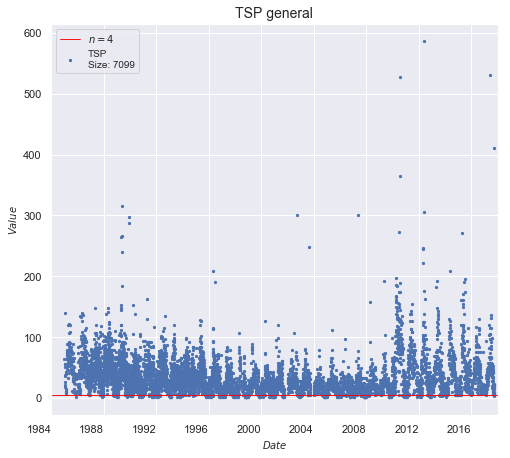

In [81]:
fig1 = PlotElement(ELEM['all'],ELEM_NAME,'general',8,8,4)
fig1.savefig(ELEM_NAME+'_PlotAll.png', bbox_inches='tight', pad_inches=0)

In [69]:
def FitParams(values, distr, floc=0):
    fdist = getattr(st, distr)
    if not floc:
        params = fdist.fit(values, floc=floc)
    else:
        params = fdist.fit(values)
    return params

def KSOnTest(test, distr, params):  
    return kstest(test, distr, args=params)

def ChiSquareOnTest(test, distr, params):
    histo, bin_edges = np.histogram(test, bins='sqrt', density=False)
    n_bins = len(bin_edges) - 1
    f_ops = histo
    fdist = getattr(st, distr)
    cdf = fdist.cdf(bin_edges, *params)
    f_exp = len(test) * np.diff(cdf)
    
    return chisquare(f_ops, f_exp, ddof=len(params))

In [88]:
start = datetime.datetime.now()
distr_ks, params_ks, p_v_ks, distr_chi2, params_chi2, p_v_chi2 = GetBestDistribution(VALUES_NOT_NULL['all'])
print ('\nTook time: {0}'.format(datetime.datetime.now()-start))


Chi2
Best fitting distribution: invgamma
Best p value: 0.23720272370530862
Parameters for the best fit: (4.626817353534779, -16.824316843266423, 192.54994010012462)

K-S
Best fitting distribution: gengamma
Best p value: 0.6426019376694742
Parameters for the best fit: (2.4663401324108545, 0.7846132671096151, -0.04003878177690218, 10.704167840258002)

Took time: 0:00:10.211554


In [72]:
distr_params_all = defaultdict(dict)
if p_v_ks >= 0.05:
    distr_params_all['general'][distr_ks] = params_ks
if p_v_chi2 >= 0.05:
    distr_params_all['general'][distr_chi2] = params_chi2

In [74]:
#GAMMA

#проверим на гамма распределение "более внимательно"
test_size = 0.2

while True: 
    train, test = train_test_split(VALUES_NOT_NULL['all'], test_size=test_size)
    params = FitParams(train,'gamma', floc=0)
    s_chi2, p_chi2 = ChiSquareOnTest(test, 'gamma', params)
    s_ks, p_ks = KSOnTest(test, 'gamma', params)
    if p_chi2 >= 0.2 or p_ks >= 0.2:
        break
#based on chi2 and ks
#TSP
print('shape,loc,scale = {0}, p_v on Chi2 = {1}, p_v on KS = {2}'.format(params, p_chi2, p_ks))

shape,loc,scale = (1.598852354586769, 0, 22.4018140668582), p_v on Chi2 = 0.6671953252569016, p_v on KS = 0.015111119165368137


In [75]:
#GAMMA
print('GAMMA\n')

stat, p_v = KSOnTest(test, 'gamma', params)
print('KS TEST:\nPower_divergenceResult(statistic={0}, pvalue={1})'.format(stat, p_v))
stat, p_v = ChiSquareOnTest(test, 'gamma', params)
print('CHISQARE TEST:\nPower_divergenceResult(statistic={0}, pvalue={1})'.format(stat, p_v))

GAMMA

KS TEST:
Power_divergenceResult(statistic=0.041353862173679395, pvalue=0.015111119165368137)
CHISQARE TEST:
Power_divergenceResult(statistic=29.935950711523255, pvalue=0.6671953252569016)


In [76]:
distr_params_all['general']['gamma'] = params

Гистограмма для выборки TSP, сезон - general
Поверх нее строятся теоритические функции плотности вероятности с вычисленными параметрами


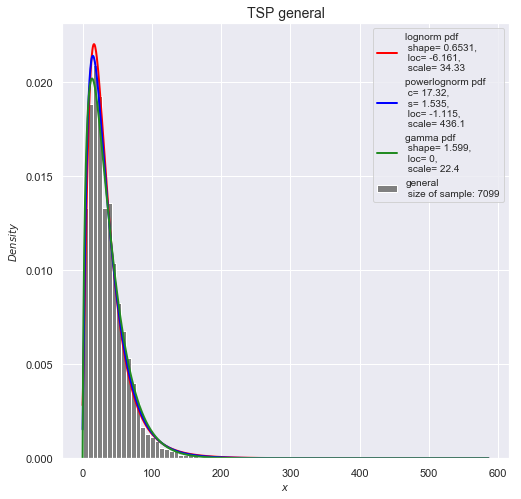

In [77]:
fig2 = DistributionBySeason(VALUES['all'], ELEM_NAME, 'general', distr_params_all['general'])
fig2.savefig(ELEM_NAME+'_DistrAll.png', bbox_inches='tight', pad_inches=0)

In [87]:
start = datetime.datetime.now()
seasons = ['winter','spring','summer','autumn']
params_seasons_ks,params_seasons_chi2 = defaultdict(dict), defaultdict(dict)
train_test_seasons1 = {}
for s in seasons:
    print()
    print(s.upper())
    print()
    distr_ks,params_ks,p_v_ks, distr_chi2,params_chi2, p_v_chi2 = GetBestDistribution(VALUES_NOT_NULL[s])
    if p_v_ks >= 0.05:
        params_seasons_ks[s][distr_ks] = params_ks
    if p_v_chi2 >= 0.05:
        params_seasons_chi2[s][distr_chi2] = params_chi2
print('\nTook time: {0}'.format(datetime.datetime.now()-start))


WINTER


Chi2
Best fitting distribution: gamma
Best p value: 0.36691151714325604
Parameters for the best fit: (1.656912669372827, 0.2552907158929993, 13.866690982729674)

K-S
Best fitting distribution: gamma
Best p value: 0.9458396152896835
Parameters for the best fit: (1.656912669372827, 0.2552907158929993, 13.866690982729674)

SPRING


Chi2
Best fitting distribution: lognorm
Best p value: 0.4395241152841976
Parameters for the best fit: (0.6017362102412449, -7.025762314176026, 46.198301193910396)

K-S
Best fitting distribution: invgamma
Best p value: 0.5084044662230804
Parameters for the best fit: (5.34736723681041, -21.21366652442788, 302.8450963434955)

SUMMER


Chi2
Best fitting distribution: lognorm
Best p value: 0.24719610487708893
Parameters for the best fit: (0.49517970388342125, -9.420248085819697, 45.97307771828348)

K-S
Best fitting distribution: genexpon
Best p value: 0.30630899009202256
Parameters for the best fit: (3.120552497074055e-08, 0.10216619880485545, 0.0706581271

In [ ]:
distr_params_seasons = defaultdict(dict)
for s in seasons:
    try:
        distr_ks, params_ks = list(params_seasons_ks[s].keys())[0], list(params_seasons_ks[s].values())[0] 
        distr_params_seasons[s][distr_ks] = params_ks
    except IndexError:
        continue
for s in seasons:
    try:
        distr_chi2, params_chi2 = list(params_seasons_chi2[s].keys())[0], list(params_seasons_chi2[s].values())[0] 
        distr_params_seasons[s][distr_chi2] = params_chi2
    except IndexError:
        continue
for s in seasons:
    params_gamma = params_seasons[s]
    distr_params_seasons[s]['gamma'] = params_gamma
for s in seasons:
    DistributionBySeason(VALUES_NOT_NULL[s], ELEM_NAME, season=s, params_dict=distr_params_seasons[s])

In [ ]:
#GAMMA
for s in seasons:
    print(s.upper())
    print()
    stat, p_v = KSOnTest(train_test_seasons[s][1], 'gamma', params_seasons[s])
    print('KS TEST:\nPower_divergenceResult(statistic={0}, pvalue={1})'.format(stat, p_v))
    stat, p_v = ChiSquareOnTest(train_test_seasons[s][1], 'gamma', params_seasons[s])
    print('CHISQARE TEST:\nPower_divergenceResult(statistic={0}, pvalue={1})'.format(stat, p_v))
    print()

Принимаем гипотезу однородности К-С, если p-value > 0.05, сопоставляем 1, иначе 0
Число подряд идущих 1 - синим цветом, 0 - серым 


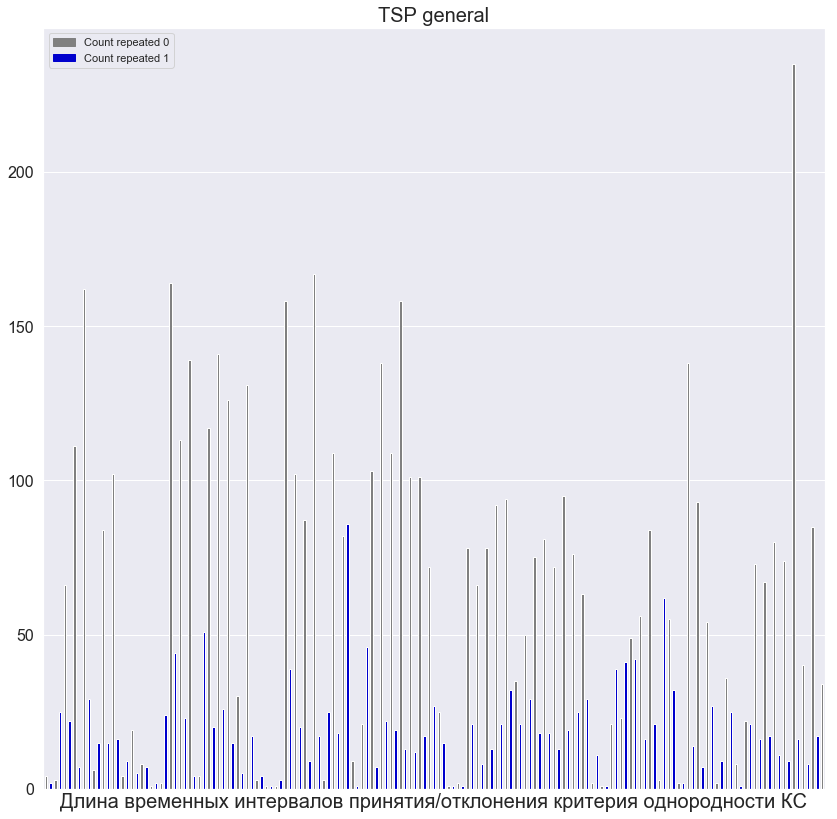

In [91]:
fig4 = HistOnRepValues(RepeatedValuesCount(KSTest2Sample(VALUES['all'])),ELEM_NAME)
fig4.savefig(ELEM_NAME+'_Contin.png', bbox_inches='tight')

The same I repeated with other polutants